# 1 - Outer Approximation Method for MINLP

We will now implement the Outer Approximation method for solving Mixed-Integer Non-Linear Programming (MINLP) Problems.

Our toy problem will be the following: 

$$
\begin{aligned}
    \underset{x, y}{ \text{minimize}} & \quad (x - 4)^2 + (y - 4)^2 \\
    \text{subject to } & \quad (x-2)^2 + (y-2)^2 - 4 \leq 0 \\
    & \quad x \in [0,4] \\
    & \quad y \in \{0,1,2,3,4\}
\end{aligned}
$$

### 1.1 - Defining the problem

In [44]:
# Import pyomo classes and functions
from pyomo.environ import *
from utils import *
from copy import deepcopy

# Print problem
def print_problem(model):
    print('Optimization Problem: \n')
    print(f"minimize: \n \t {model.obj.expr}")
    print("s.t. ")
    for c in model.component_objects(Constraint, active=True):
        for index in c:
            print(f"\t{c[index].expr}")

# Create a concrete model
mnlp = ConcreteModel()

# Define non-negative and real decision variables
mnlp.x = Var(domain=Reals, bounds=(0,4))
mnlp.y = Var(domain=Integers, bounds=(0,4))

# Define objective function (maximize -x2)
mnlp.obj = Objective(expr= (mnlp.x - 4)**2 + (mnlp.y - 4)**2, sense=minimize)

# Define constraints
g = (mnlp.x-2)**2 + (mnlp.y-2)**2 - 4
mnlp.con1 = Constraint(expr= g <= 0)

# Printing MNLP
print_problem(mnlp)

# Solve using GLPK solver
solver = SolverFactory('gurobi')

Optimization Problem: 

minimize: 
 	 (x - 4)**2 + (y - 4)**2
s.t. 
	(x - 2)**2 + (y - 2)**2 - 4  <=  0


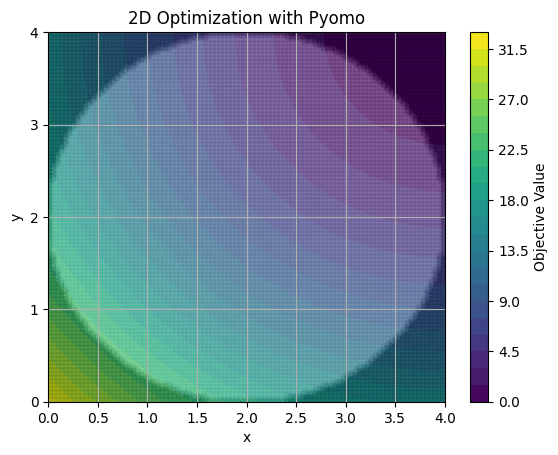

In [2]:
plot_model(mnlp)

In [45]:
def outer_approx(model, nlp_solver_name='gurobi', milp_solver_name='gurobi'):

    # Initializing solvers
    nlp_solver = SolverFactory(nlp_solver_name)
    milp_solver = SolverFactory(milp_solver_name)

    # Get variable information
    var_info ={'integer':[], 'real':[]}
    for v in model.component_objects(Var, active=True):
        if v.domain == Integers:
            var_info['integer'].append(v)
        else:
            var_info['real'].append(v)

    # Integer relaxation -> Get first estimate
    solve_nlp(model, nlp_solver, var_info)

    # Build master problem

    return var_info

def solve_nlp(model, solver, var_info):

    nlp = model

    for var in var_info['integer']:
        var.domain = Reals

    result = solver.solve(nlp)

def build_master(model):
    

In [46]:
var_info = outer_approx(mnlp)

In [51]:
var_info['real'][0]()

3.4142135587933238

### 1.2 - Relaxing Integer constraint on _y_ (NLP)
Allowing _y_ to be a real number instead of an integer.

In [32]:
nlp = mnlp

nlp.y.domain = Reals

result = solver.solve(nlp)
x_sol = value(nlp.x)
y_sol = value(nlp.y)
print(f"x0 = {x_sol}, y0 = {y_sol}, nlp = {nlp.obj()}")

x0 = 3.4142135587933238, y0 = 3.414213558793325, nlp = 0.6862915094031639


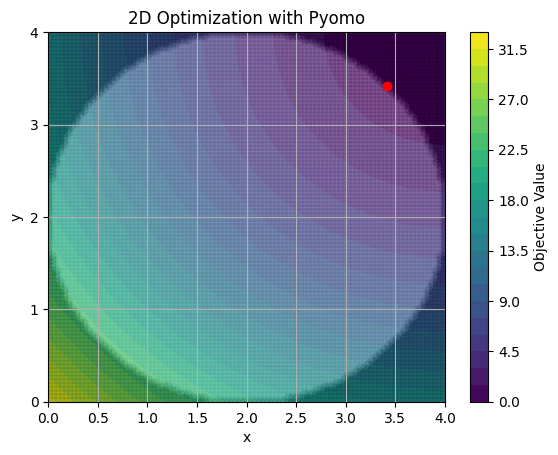

In [4]:
plot_model(nlp)
plt.scatter(x_sol, y_sol, c='red')
plt.show()

### 1.3 -  Building Master Problem

Using the solution from the NLP (1.2) to build the MILP.

In [5]:
master = ConcreteModel()

# Define non-negative and real decision variables
master.x = Var(domain=Reals, bounds=(0,4))
master.y = Var(domain=Integers, bounds=(0,4))
master.mu = Var(domain=Reals)

# Objective
master.obj = Objective(expr= master.mu, sense=minimize)

# Constraints
df_dx = differentiate(mnlp.obj.expr, wrt=mnlp.x)
df_dy = differentiate(mnlp.obj.expr, wrt=mnlp.y)
master.con1 = Constraint(expr= mnlp.obj() + df_dx*(master.x - x_sol) + df_dy*(master.y - y_sol)<=master.mu)
dg_dx = differentiate(g, wrt=mnlp.x)
dg_dy = differentiate(g, wrt=mnlp.y)
master.con2 = Constraint(expr= g() + dg_dx*(master.x - x_sol) + dg_dy*(master.y - y_sol) <= 0)

result = solver.solve(master)

# Print problem
print_problem(master)

# Print results
x_sol = value(master.x)
y_sol = value(master.y)
print(f"\nSoluion: x = {x_sol}, y = {y_sol}, mu = {master.mu()}")

Optimization Problem: 

minimize: 
 	 mu
s.t. 
	0.6862915094031639 - 1.1715728824133524*(x - 3.4142135587933238) - 1.1715728824133498*(y - 3.414213558793325)  <=  mu
	-2.0250240595487412e-08 + 2.8284271175866476*(x - 3.4142135587933238) + 2.82842711758665*(y - 3.414213558793325)  <=  0

Soluion: x = 2.8284271247461903, y = 4.0, mu = 0.6862915010152406


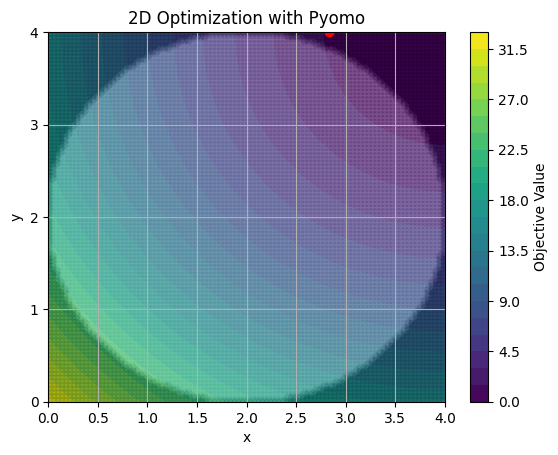

In [6]:
plot_model(mnlp)
plt.scatter(x_sol, y_sol, c='red')

### 1.4 - Fix _y_ and solve the NLP
Use the _y_ from the solution of (1.3) to build an NLP.

In [7]:
nlp = mnlp

nlp.y.fix(master.y())  # Fix y to 4.0 and make it immune to optimization

result = solver.solve(nlp)
x_sol = value(nlp.x)
y_sol = value(nlp.y)
print(f"x0 = {x_sol}, y0 = {y_sol}, nlp = {nlp.obj()}")

x0 = 2.0, y0 = 4.0, nlp = 4.0


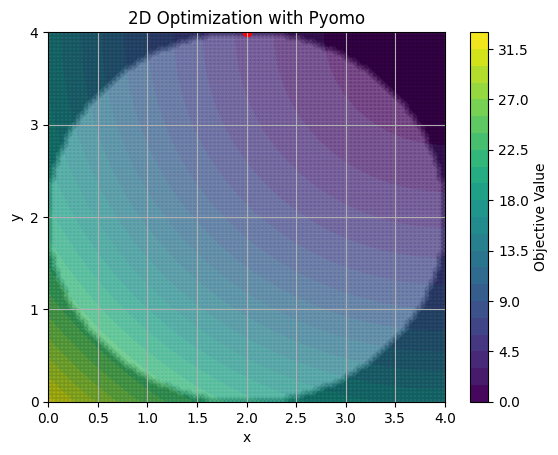

In [8]:
plot_model(nlp)
plt.scatter(x_sol, y_sol, c='red')
plt.show()

### 1.5 - Update the Master Problem
Use solution from (1.4) to add new linear constraints to the Master problem.

In [9]:
# Constraints
df_dx = differentiate(mnlp.obj.expr, wrt=mnlp.x)
df_dy = differentiate(mnlp.obj.expr, wrt=mnlp.y)
master.con3 = Constraint(expr= mnlp.obj() + df_dx*(master.x - nlp.x()) + df_dy*(master.y - nlp.y())<=master.mu)

dg_dx = differentiate(g, wrt=mnlp.x)
dg_dy = differentiate(g, wrt=mnlp.y)
master.con4 = Constraint(expr= g() + dg_dx*(master.x - nlp.x()) + dg_dy*(master.y - nlp.y()) <= 0)

result = solver.solve(master)

# Print problem
print_problem(master)

# Print results
x_sol = value(master.x)
y_sol = value(master.y)
print(f"\nSoluion: x = {master.x()}, y = {master.y()}")

Optimization Problem: 

minimize: 
 	 mu
s.t. 
	0.6862915094031639 - 1.1715728824133524*(x - 3.4142135587933238) - 1.1715728824133498*(y - 3.414213558793325)  <=  mu
	-2.0250240595487412e-08 + 2.8284271175866476*(x - 3.4142135587933238) + 2.82842711758665*(y - 3.414213558793325)  <=  0
	4.0 - 4.0*(x - 2.0) + 0.0*(y - 4.0)  <=  mu
	0.0*(x - 2.0) + 4.0*(y - 4.0)  <=  0

Soluion: x = 3.828427124746196, y = 3.0


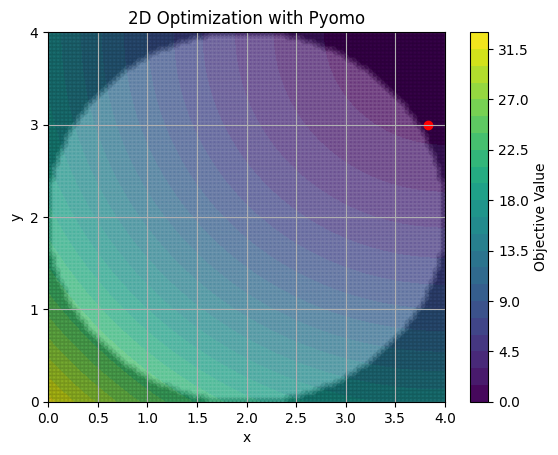

In [10]:
plot_model(mnlp)
plt.scatter(x_sol, y_sol, c='red')

### 1.6 - Fix _y_ and solve the NLP
Use solution from (1.4) to add new linear constraints to the Master problem.

In [11]:
nlp = mnlp

nlp.y.fix(master.y())  # Fix y to 4.0 and make it immune to optimization

result = solver.solve(nlp)
x_sol = value(nlp.x)
y_sol = value(nlp.y)
print(f"x0 = {x_sol}, y0 = {y_sol}, nlp = {nlp.obj()}")

x0 = 3.732050807568877, y0 = 3.0, nlp = 1.0717967697244908


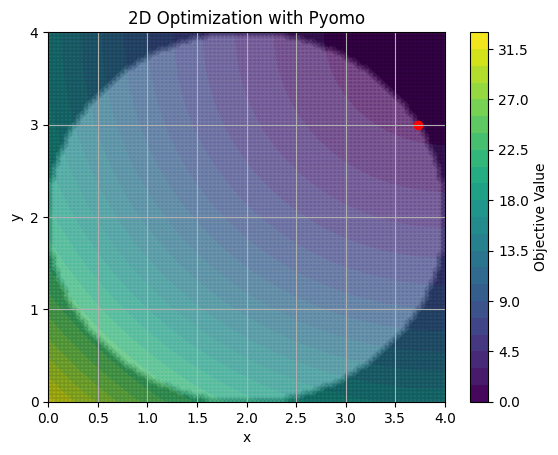

In [13]:
plot_model(mnlp)
plt.scatter(x_sol, y_sol, c='red')